In [9]:
import joblib

best_logreg = joblib.load('../Day_12/model.pkl')
best_gb = joblib.load("../Day_13/gb_model.pkl")

from sklearn.compose import ColumnTransformer

# preprocessor = best_logreg.named_steps["preprocessor"]

# # Extract categorical + numerical feature names after transformation
# cat_features = preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(preprocessor.transformers_[1][2])
# num_features = preprocessor.transformers_[0][2]

# expected_features = list(num_features) + list(cat_features)

# expected_features

In [16]:
import numpy as np

pipe = best_logreg
pre  = pipe.named_steps["preprocessor"]

num_cols = list(pre.transformers_[0][2])
cat_cols = list(pre.transformers_[1][2])

cat_t = pre.named_transformers_["cat"]
try:
    ohe = cat_t.named_steps["onehot"]   # works if cat branch is a mini-pipeline
except AttributeError:
    ohe = cat_t                         # otherwise it’s the OHE itself

# Expand categorical names
if hasattr(ohe, "get_feature_names_out"):
    cat_names = list(ohe.get_feature_names_out(cat_cols))
else:
    cat_names = list(ohe.get_feature_names(cat_cols))

expected_features = num_cols + cat_names

# Coefficients from the trained logistic regression
clf   = pipe.named_steps["classifier"]
coefs = clf.coef_.ravel()

print("features:", len(expected_features), "| coefs:", len(coefs))


features: 44 | coefs: 44


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Build a tidy table
imp = pd.DataFrame({
    "feature": expected_features,
    "coef": coefs
})
imp["abs_coef"] = np.abs(imp["coef"])

# 2) Top N features by |coef|
TOP_N = 10
top_imp = imp.sort_values("abs_coef", ascending=False).head(TOP_N)
top_imp


,feature,coef,abs_coef
37,JobRole_Research Director,-2.035962,2.035962
20,BusinessTravel_Non-Travel,-1.349021,1.349021
40,JobRole_Sales Representative,1.278163,1.278163
30,EducationField_Other,-1.045939,1.045939
34,JobRole_Laboratory Technician,0.979127,0.979127
32,JobRole_Healthcare Representative,-0.957766,0.957766
26,EducationField_Human Resources,0.867202,0.867202
23,Department_Human Resources,-0.738684,0.738684
36,JobRole_Manufacturing Director,-0.659503,0.659503
33,JobRole_Human Resources,0.651599,0.651599


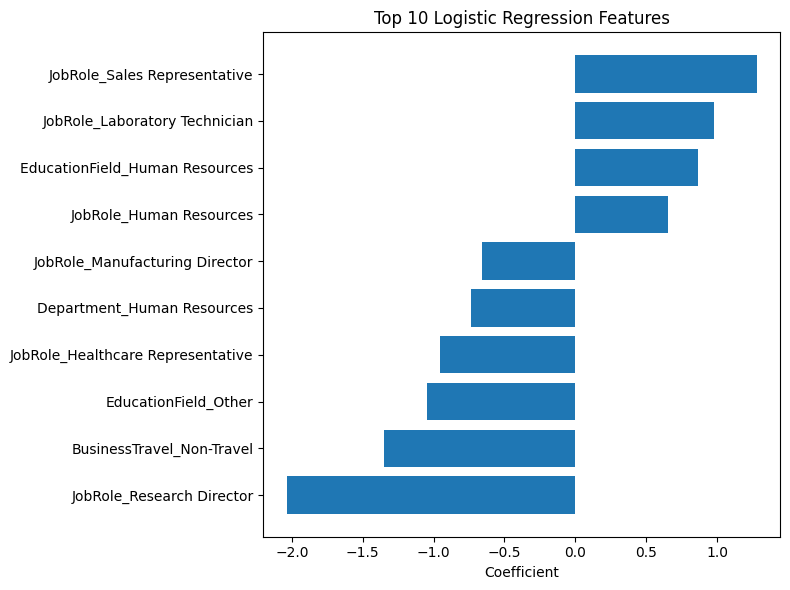

In [18]:
# Sort for a tidy horizontal bar chart
top_imp_sorted = top_imp.sort_values("coef")
plt.figure(figsize=(8, 6))
plt.barh(top_imp_sorted["feature"], top_imp_sorted["coef"])
plt.title("Top 10 Logistic Regression Features")
plt.xlabel("Coefficient")
plt.tight_layout()
plt.show()


In [23]:
import joblib
gb_pipe = joblib.load("../Day_13/gb_model.pkl")   

import numpy as np

pre = gb_pipe.named_steps["preprocess"]

num_cols = list(pre.transformers_[0][2])
cat_cols = list(pre.transformers_[1][2])

cat_t = pre.named_transformers_["cat"]
try:
    ohe = cat_t.named_steps["onehot"]   # if cat branch is a mini-pipeline
except AttributeError:
    ohe = cat_t                         # if it’s directly an OHE

if hasattr(ohe, "get_feature_names_out"):
    cat_names = list(ohe.get_feature_names_out(cat_cols))
else:
    cat_names = list(ohe.get_feature_names(cat_cols))

gb_features = num_cols + cat_names



In [24]:
from sklearn.ensemble import GradientBoostingClassifier  # just for type clarity

gb_clf = gb_pipe.named_steps["classifier"]
importances = gb_clf.feature_importances_

assert len(importances) == len(gb_features), "Length mismatch!"


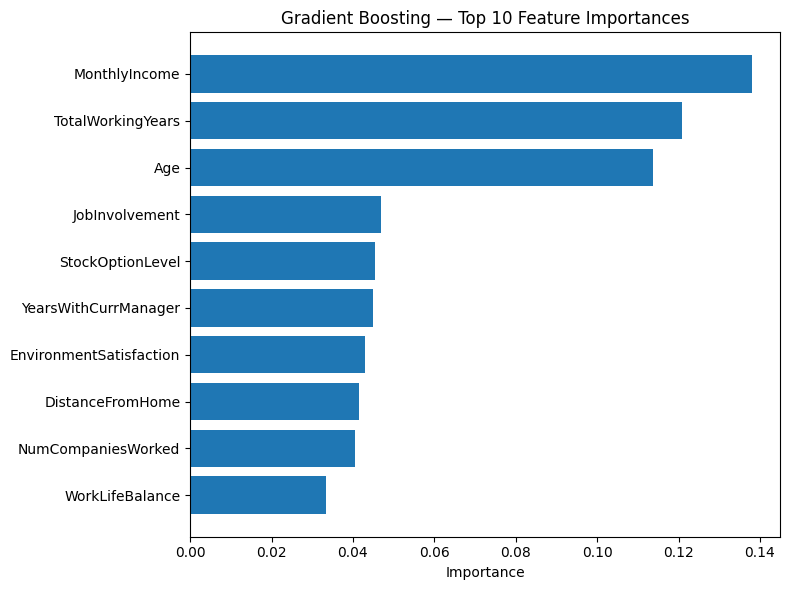

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

gb_imp = pd.DataFrame({"feature": gb_features, "importance": importances})
gb_top = gb_imp.sort_values("importance", ascending=False).head(10)

# Plot
gb_top_sorted = gb_top.sort_values("importance")
plt.figure(figsize=(8,6))
plt.barh(gb_top_sorted["feature"], gb_top_sorted["importance"])
plt.title("Gradient Boosting — Top 10 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [26]:


lr_df = pd.DataFrame({
    "feature": expected_features,   
    "lr_coef": coefs
})
lr_df["lr_abs_coef"] = np.abs(lr_df["lr_coef"])


gb_df = pd.DataFrame({
    "feature": gb_features,         
    "gb_importance": importances
})


merged = pd.merge(lr_df, gb_df, on="feature", how="outer")

# Optional: sort by whichever you want to focus on (e.g., LR abs coef or GB importance)
merged_sorted = merged.sort_values("lr_abs_coef", ascending=False)

# Show top 15 features
merged_sorted.head(15)


,feature,lr_coef,lr_abs_coef,gb_importance
23,JobRole_Research Director,-2.035962,2.035962,0.000780
1,BusinessTravel_Non-Travel,-1.349021,1.349021,0.010563
26,JobRole_Sales Representative,1.278163,1.278163,0.007959
13,EducationField_Other,-1.045939,1.045939,0.000000
20,JobRole_Laboratory Technician,0.979127,0.979127,0.020568
18,JobRole_Healthcare Representative,-0.957766,0.957766,0.000000
9,EducationField_Human Resources,0.867202,0.867202,0.005215
4,Department_Human Resources,-0.738684,0.738684,0.000000
22,JobRole_Manufacturing Director,-0.659503,0.659503,0.000000
19,JobRole_Human Resources,0.651599,0.651599,0.000659
